In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
%matplotlib inline

In [5]:
class DataPlotter:
    def __init__(self, dataset) -> None:
        self.dataset = dataset

    def get_all_features_observed(self):
        x_train_observed = pd.read_parquet(self.dataset + '/X_train_observed.parquet')
        return x_train_observed.columns

    def get_all_features_estimated(self):
        x_train_estimated = pd.read_parquet(self.dataset + '/X_train_estimated.parquet')
        return x_train_estimated.columns
    
    def get_correlation(self, df, feature):
        with np.errstate(divide='ignore', invalid='ignore'):
            correlation = df[feature].corr(df['pv_measurement'])
            if np.isnan(correlation) or np.isinf(correlation):
                correlation = 0.0  # Handle the case when correlation is NaN or Inf
        return correlation

    def handle_nan(self, val):
        if math.isnan(val):
            print("The correlation is NaN. Handling it...")
            val = 0
            return val
        return val
    
    def plot_feature_against_y(self, feature, observed, plot, hour=None, month=None):
        if observed:
            y_train = pd.read_parquet(self.dataset + '/train_targets.parquet')
            x_train = pd.read_parquet(self.dataset + '/X_train_observed.parquet')
        else:
            y_train = pd.read_parquet(self.dataset + '/train_targets.parquet')
            x_train = pd.read_parquet(self.dataset + '/X_train_estimated.parquet')
        
        # Convert 'time' and 'date_forecast' columns to datetime format
        y_train['time'] = pd.to_datetime(y_train['time'])
        x_train['date_forecast'] = pd.to_datetime(x_train['date_forecast'])

        if (hour and month) is not None:
            #print("HOUR =", hour,"AND MONTH =", month)
            y_train_at_hour_and_month = y_train[
                (y_train['time'].dt.hour == hour) & (y_train['time'].dt.month == month)
            ]
            x_train_at_hour_and_month = x_train[
                (x_train['date_forecast'].dt.hour == hour) & (x_train['date_forecast'].dt.month == month)
            ]
            merged_df = pd.merge(
                y_train_at_hour_and_month, x_train_at_hour_and_month,
                left_on='time', right_on='date_forecast'
            )
            corr = self.get_correlation(df = merged_df, feature=feature)
            #print('The correlation is', self.handle_nan(corr))
        elif hour is not None and month is None:
            #print("HOUR =", hour)
            y_train_at_hour = y_train[y_train['time'].dt.hour == hour]
            x_train_at_hour = x_train[x_train['date_forecast'].dt.hour == hour]
            merged_df = pd.merge(
                y_train_at_hour, x_train_at_hour, left_on='time', right_on='date_forecast'
            )
            corr = self.get_correlation(df = merged_df, feature=feature)
            #print('The correlation is', self.handle_nan(corr))
        elif month is not None and hour is None:
            #print("MONTH =", month)
            y_train_at_month = y_train[y_train['time'].dt.month == month]
            x_train_at_month = x_train[x_train['date_forecast'].dt.month == month]
            merged_df = pd.merge(
                y_train_at_month, x_train_at_month, left_on='time', right_on='date_forecast'
            )
            corr = self.get_correlation(df = merged_df, feature=feature)
            #print('The correlation is', self.handle_nan(corr))
        elif not month and not hour:
            #print(y_train.columns)
            merged_df = pd.merge(y_train , x_train, left_on='time', right_on='date_forecast')
            corr = self.get_correlation(df = merged_df, feature=feature)
            #print('The correlation is', self.handle_nan(corr))

        if plot:
            plt.figure(figsize=(6, 4))
            plt.scatter(merged_df[feature], merged_df['pv_measurement'], alpha=1)
            plt.xlabel(feature)
            plt.ylabel('PV Measurement')
            plt.title(feature + ' vs PV Measurement')
            plt.grid(True)
            plt.show()

        if math.isnan(corr):
            return 0
        
        return corr
    
    def plot_feature_analysis(self, observed, plot, feature=None, hour=None, month=None):
        if observed:
            if feature:
                print(feature + " FROM OBSERVED DATASET FROM LOCATION " + self.dataset + ".")
                corr = self.plot_feature_against_y(feature, observed=True, plot=plot, hour=hour, month=month)
                return corr
            else:
                print("ALL FEATURES PLOTTED FROM OBSERVED DATASET FROM LOCATION " + self.dataset + ".")
                for feature in self.get_all_features_observed():
                    self.plot_feature_against_y(feature, observed=True, plot=plot, hour=hour, month=month)
        else:
            if feature:
                print(feature + " FROM ESTIMATED DATASET FROM LOCATION " + self.dataset + ".")
                corr = self.plot_feature_against_y(feature, observed=False, plot=plot, hour=hour, month = month)
                return corr
            else:
                print("ALL FEATURES PLOTTED FROM ESTIMATED DATASET FROM LOCATION " + self.dataset + ".")
                for feature in self.get_all_features_estimated():
                    self.plot_feature_against_y(feature, observed=False, plot=plot, hour=hour, month = month)

In [6]:
# Choose what dataset you want your values from (observed = False gets the estimated dataset).
# This will output all features in the dataset

dataset = 'A'
observed = True

plotter = DataPlotter(dataset)

if observed: print(plotter.get_all_features_observed())
else: print(plotter.get_all_features_estimated())

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

diffuse_rad:W FROM OBSERVED DATASET FROM LOCATION A.


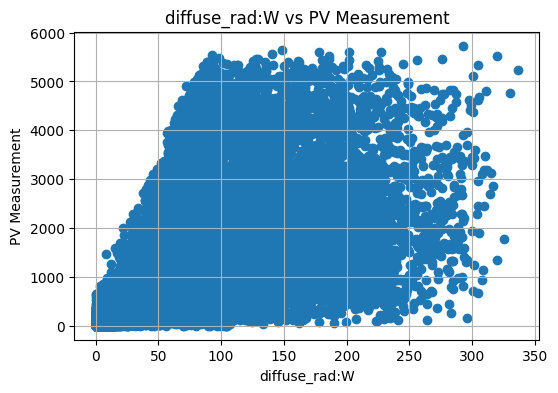

Correlation is 0.7057036621316238


In [7]:
# Spesify hour (example: 12) and/or month (example: 6). Either of them can be None.
# Choose your feature. If you spesify 'feature' to be None, then it will plot for ALL feautures.

hour = None
month = None
feature = 'diffuse_rad:W'

corr = plotter.plot_feature_analysis(observed=observed, plot=True, feature=feature, hour=hour, month=month)
if corr is not None:
    print("Correlation is", corr)

In [8]:
class Observation:
    def __init__(self, feature, hour, month, corr) -> None:
        self.feature = feature
        self.hour = hour
        self.month = month
        self.corr = corr

In [118]:
# ITERATE THROUGH ALL COMBINATIONS OF MONTHS AND HOURS FOR A CHOSEN LOCATION AND SORT ON CORRELATION
# CREATES .CSV FILE
# NOTE Takes a long time to run

dataset = 'C'
observed = False

########################################################################################################################

if observed: all_features = plotter.get_all_features_observed()
else: plotter.get_all_features_estimated()

hours = list(range(24))
months = list(range(1, 13))

observations = []
for feature in all_features:
    for hour in hours:
        for month in months:
            corr = plotter.plot_feature_against_y(feature=feature, observed=observed, plot=False, hour=hour, month=month)
            obsvervation = Observation(feature, hour, month, corr)
            observations.append(obsvervation)

sorted_observations = sorted(observations, key=lambda x: -abs(x.corr))

if observed: csv_filename = "sorted_feature_correlations_" + dataset + "_observed.csv"
else: csv_filename = "sorted_feature_correlations_" + dataset + "_estimated.csv"

with open(csv_filename, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Feature', 'Hour', 'Month', 'Correlation'])

    for obs in sorted_observations:
        row_data = [obs.feature, obs.hour, obs.month, obs.corr]
        csv_writer.writerow(row_data)

print(f"CSV file '{csv_filename}' has been created.")


/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of 

CSV file 'sorted_feature_correlations_C_estimated.csv' has been created.


In [9]:
# Outputs top features with the highest correlations

location = 'A'
observed = True

if observed: csv_filename = location + "/sorted_feature_correlations_" + location + "_observed.csv"
else: csv_filename = location + "/sorted_feature_correlations_" + location + "_estimated.csv"

data_a = pd.read_csv(csv_filename)
data_a.head(10)

,Feature,Hour,Month,Correlation
0,diffuse_rad:W,18,4,0.844827
1,diffuse_rad:W,17,9,0.823194
2,direct_rad:W,7,7,0.820051
3,diffuse_rad:W,16,10,0.819249
4,direct_rad:W,18,4,0.817479
5,direct_rad:W,7,4,0.813259
6,direct_rad_1h:J,7,7,0.812555
7,diffuse_rad:W,20,8,0.812173
8,diffuse_rad:W,19,4,0.809068
9,direct_rad:W,19,4,0.808345


In [10]:
# The most highly correlated value for every month

data_a['Month'] = pd.Categorical(data_a['Month'], categories=data_a['Month'].unique(), ordered=True)
max_corr_rows = pd.DataFrame()

for month in data_a['Month'].cat.categories:
    monthly_data = data_a[data_a['Month'] == month]
    
    max_corr_idx = monthly_data['Correlation'].idxmax()
    
    max_corr_rows = pd.concat([max_corr_rows, data_a.loc[[max_corr_idx]]], ignore_index=True)

# Sort max_corr_rows by the 'Month' column
max_corr_rows['Month'] = max_corr_rows['Month'].astype(int)  # Ensure 'Month' is an integer type for proper sorting
max_corr_rows.sort_values('Month', inplace=True)
max_corr_rows.reset_index(drop=True, inplace=True)

max_corr_rows

,Feature,Hour,Month,Correlation
0,direct_rad:W,13,1,0.715412
1,diffuse_rad:W,16,2,0.774792
2,direct_rad:W,15,3,0.784733
3,diffuse_rad:W,18,4,0.844827
4,direct_rad:W,19,5,0.807000
5,direct_rad:W,8,6,0.775839
6,direct_rad:W,7,7,0.820051
7,diffuse_rad:W,20,8,0.812173
8,diffuse_rad:W,17,9,0.823194
9,diffuse_rad:W,16,10,0.819249


In [11]:
# The most highly correlated value for every hour

max_corr_rows = pd.DataFrame()

for hour in range(0, 24):  
    hourly_data = data_a[data_a['Hour'] == hour]
    
    if not hourly_data.empty:  
        max_corr_idx = hourly_data['Correlation'].idxmax()
        max_corr_rows = pd.concat([max_corr_rows, data_a.loc[[max_corr_idx]]], ignore_index=True)

max_corr_rows.sort_values('Hour', inplace=True)
max_corr_rows.reset_index(drop=True, inplace=True)

max_corr_rows


,Feature,Hour,Month,Correlation
0,sfc_pressure:hPa,0,6,0.183985
1,visibility:m,1,6,0.474844
2,diffuse_rad:W,2,7,0.773390
3,diffuse_rad:W,3,5,0.744497
4,direct_rad:W,4,7,0.745944
5,direct_rad_1h:J,5,9,0.765301
6,direct_rad:W,6,7,0.803967
7,direct_rad:W,7,7,0.820051
8,direct_rad:W,8,7,0.782311
9,direct_rad:W,9,9,0.798511


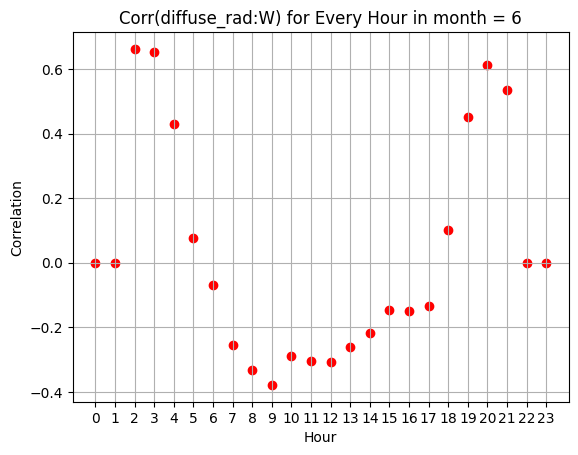

In [12]:
# Plot a the correlation of a feature for a spesific month for every hour
# Choose month and feature

month = 6
feature = 'diffuse_rad:W'

filtered_data = data_a[(data_a['Feature'] == feature) & (data_a['Month'] == month)]

# Creating a scatter plot of the correlation values for each hour.
plt.scatter(filtered_data['Hour'], filtered_data['Correlation'], color='red')
plt.xticks(range(0, 24))  
plt.title('Corr(' + feature + ') for Every Hour in month = ' + str(month))
plt.xlabel('Hour')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()


/var/folders/h4/_4wngf5n4793mylk022tqrrh0000gn/T/ipykernel_23214/3882467950.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg_corr = filtered_data.groupby('Month')['Correlation'].mean()


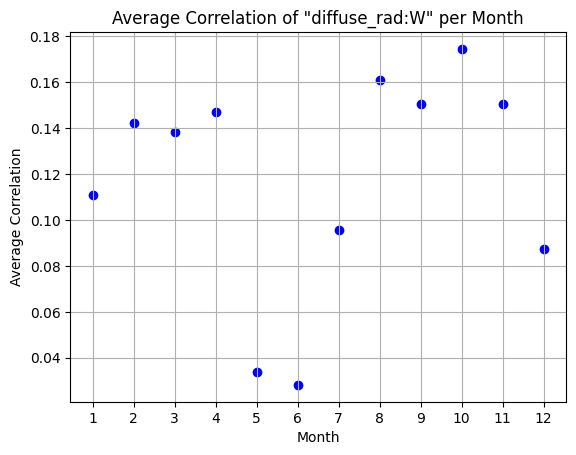

In [13]:
filtered_data = data_a.loc[data_a['Feature'] == 'diffuse_rad:W']

monthly_avg_corr = filtered_data.groupby('Month')['Correlation'].mean()

monthly_avg_corr = monthly_avg_corr.sort_index()

plt.scatter(monthly_avg_corr.index, monthly_avg_corr.values, color='blue')
plt.xticks(monthly_avg_corr.index)  # Ensure all months are displayed on the x-axis.
plt.title('Average Correlation of "diffuse_rad:W" per Month')
plt.xlabel('Month')
plt.ylabel('Average Correlation')
plt.grid(True)
plt.show()


# Lets do some Exploratory Analysis

Let us examine the data more carefully using pandas.

In [14]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

## Differing times for each location

- Each location begins to record at a different date, although they all end at the same date. 
- Another thing of notice is that location B seems to start its readings the earliest, then comes A and C at least with quite a significant margin.

train_a head:


,time,pv_measurement
0,2019-06-02 22:00:00,0.0
1,2019-06-02 23:00:00,0.0
2,2019-06-03 00:00:00,0.0


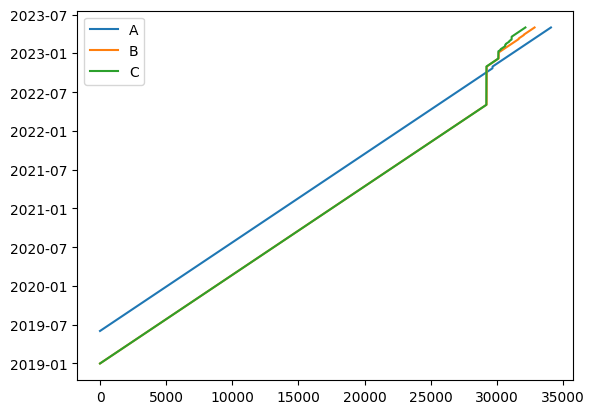

In [54]:
train_a['time'].plot(label="A")
train_b['time'].plot(label="B")
train_c['time'].plot(label="C")
plt.legend()

print("train_a head:")
train_a.head(3)

## How about plotting pv measurment against time for all three locations?

Thing of notice:
- The amplitude of the readings from location A are much higher than the other two locations.

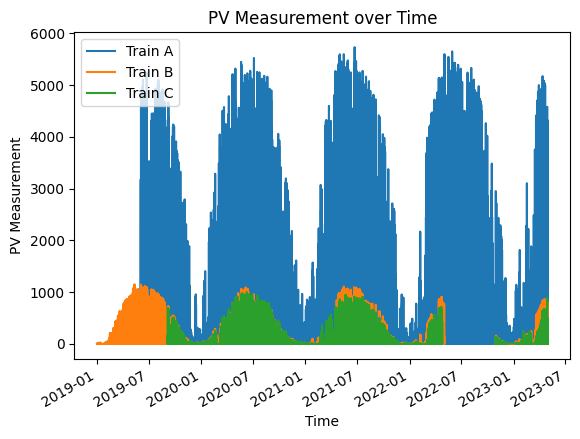

In [49]:
fig, ax = plt.subplots()

train_a.plot(x='time', y='pv_measurement', ax=ax, label='Train A')
train_b.plot(x='time', y='pv_measurement', ax=ax, label='Train B')
train_c.plot(x='time', y='pv_measurement', ax=ax, label='Train C')

ax.set_xlabel('Time')
ax.set_ylabel('PV Measurement')
ax.set_title('PV Measurement over Time')
ax.legend()

plt.show()

## What day are we trying to predict on?

It turns out it is 31st of April 2023. This is because all the y-train data for all the locations end on April 30th. This information might be useful since for every month the best predicting feature are differening. Moreover the power output in the winter is not the same as in spring.

In [48]:
train_a['time'].max(), train_b['time'].max(), train_c['time'].max()

(Timestamp('2023-04-30 23:00:00'),
 Timestamp('2023-04-30 23:00:00'),
 Timestamp('2023-04-30 23:00:00'))

## Let us examin both the observed and estimated dataset for all the locations starting with A

We will examine 
- Datashapes
- Datatypes
- Columns
- NaN values
- Some plots
- A correlation matrix

In [15]:
X_train_observed_a.head()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2019-06-02 22:00:00,7.7,1.230,1744.900024,0.0,0.0,1744.900024,0.0,280.299988,0.0,...,342.834015,-3.202,0.0,285.899994,100.0,39640.101562,3.7,-3.6,-0.8,-0.0
1,2019-06-02 22:15:00,7.7,1.229,1734.000000,0.0,0.0,1734.000000,0.0,280.299988,0.0,...,346.294006,-3.650,0.0,286.100006,100.0,40123.898438,3.6,-3.6,-0.6,-0.0
2,2019-06-02 22:30:00,7.7,1.228,1723.500000,0.0,0.0,1723.500000,0.0,280.299988,0.0,...,349.768005,-3.998,0.0,286.299988,100.0,40628.300781,3.6,-3.6,-0.4,-0.0
3,2019-06-02 22:45:00,7.7,1.226,1713.400024,0.0,0.0,1713.400024,0.0,280.299988,0.0,...,353.251007,-4.247,0.0,286.600006,100.0,41153.601562,3.5,-3.5,-0.2,-0.0
4,2019-06-02 23:00:00,7.7,1.225,1703.599976,0.0,0.0,1703.599976,0.0,280.299988,0.0,...,356.742004,-4.393,0.0,286.799988,100.0,41699.898438,3.5,-3.5,0.0,-0.0


In [16]:
X_train_estimated_a.shape, X_train_observed_a.shape


((17576, 47), (118669, 46))

In [17]:
X_train_observed_a.dtypes

date_forecast                     datetime64[us]
absolute_humidity_2m:gm3                 float32
air_density_2m:kgm3                      float32
ceiling_height_agl:m                     float32
clear_sky_energy_1h:J                    float32
clear_sky_rad:W                          float32
cloud_base_agl:m                         float32
dew_or_rime:idx                          float32
dew_point_2m:K                           float32
diffuse_rad:W                            float32
diffuse_rad_1h:J                         float32
direct_rad:W                             float32
direct_rad_1h:J                          float32
effective_cloud_cover:p                  float32
elevation:m                              float32
fresh_snow_12h:cm                        float32
fresh_snow_1h:cm                         float32
fresh_snow_24h:cm                        float32
fresh_snow_3h:cm                         float32
fresh_snow_6h:cm                         float32
is_day:idx          

In [18]:
X_train_observed_a.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

In [19]:
X_train_observed_a.isna().sum()

date_forecast                          0
absolute_humidity_2m:gm3               0
air_density_2m:kgm3                    0
ceiling_height_agl:m               22247
clear_sky_energy_1h:J                  0
clear_sky_rad:W                        0
cloud_base_agl:m                    8066
dew_or_rime:idx                        0
dew_point_2m:K                         0
diffuse_rad:W                          0
diffuse_rad_1h:J                       0
direct_rad:W                           0
direct_rad_1h:J                        0
effective_cloud_cover:p                0
elevation:m                            0
fresh_snow_12h:cm                      0
fresh_snow_1h:cm                       0
fresh_snow_24h:cm                      0
fresh_snow_3h:cm                       0
fresh_snow_6h:cm                       0
is_day:idx                             0
is_in_shadow:idx                       0
msl_pressure:hPa                       0
precip_5min:mm                         0
precip_type_5min

In [20]:
X_train_estimated_a.isna().sum()

date_calc                             0
date_forecast                         0
absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
ceiling_height_agl:m               3919
clear_sky_energy_1h:J                 0
clear_sky_rad:W                       0
cloud_base_agl:m                   2094
dew_or_rime:idx                       0
dew_point_2m:K                        0
diffuse_rad:W                         0
diffuse_rad_1h:J                      0
direct_rad:W                          0
direct_rad_1h:J                       0
effective_cloud_cover:p               0
elevation:m                           0
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                            0
is_in_shadow:idx                      0
msl_pressure:hPa                      0
precip_5min:mm                        0


In [21]:
X_train_observed_a.loc[X_train_observed_a.duplicated()]

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms


In [22]:
X_train_estimated_a.loc[X_train_estimated_a.duplicated()]

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms


<Axes: xlabel='diffuse_rad:W'>

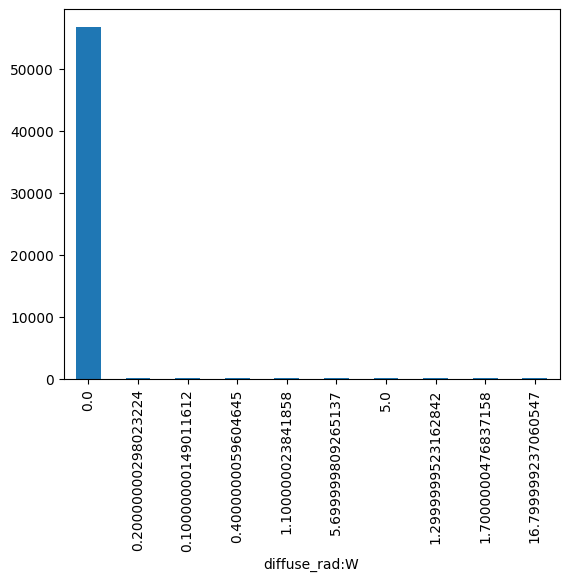

In [23]:
X_train_observed_a['diffuse_rad:W'].value_counts() \
    .head(10) \
    .plot(kind='bar')

In [24]:
merged = pd.merge(train_a , X_train_observed_a, left_on='time', right_on='date_forecast')
mask = merged['diffuse_rad:W'] > 0

filtered_data = merged[mask]
dates_above_zero = filtered_data['time']
print(dates_above_zero)

cond = X_train_observed_a['date_forecast'] == '2022-10-20 11:00:00'
filtered = X_train_observed_a[cond]
print("-------------------------------")
print(filtered['diffuse_rad:W'])


4       2019-06-03 02:00:00
5       2019-06-03 03:00:00
6       2019-06-03 04:00:00
7       2019-06-03 05:00:00
8       2019-06-03 06:00:00
                ...        
29653   2022-10-20 11:00:00
29654   2022-10-20 12:00:00
29655   2022-10-20 13:00:00
29656   2022-10-20 14:00:00
29657   2022-10-20 15:00:00
Name: time, Length: 15463, dtype: datetime64[us]
-------------------------------
118612    90.400002
Name: diffuse_rad:W, dtype: float32


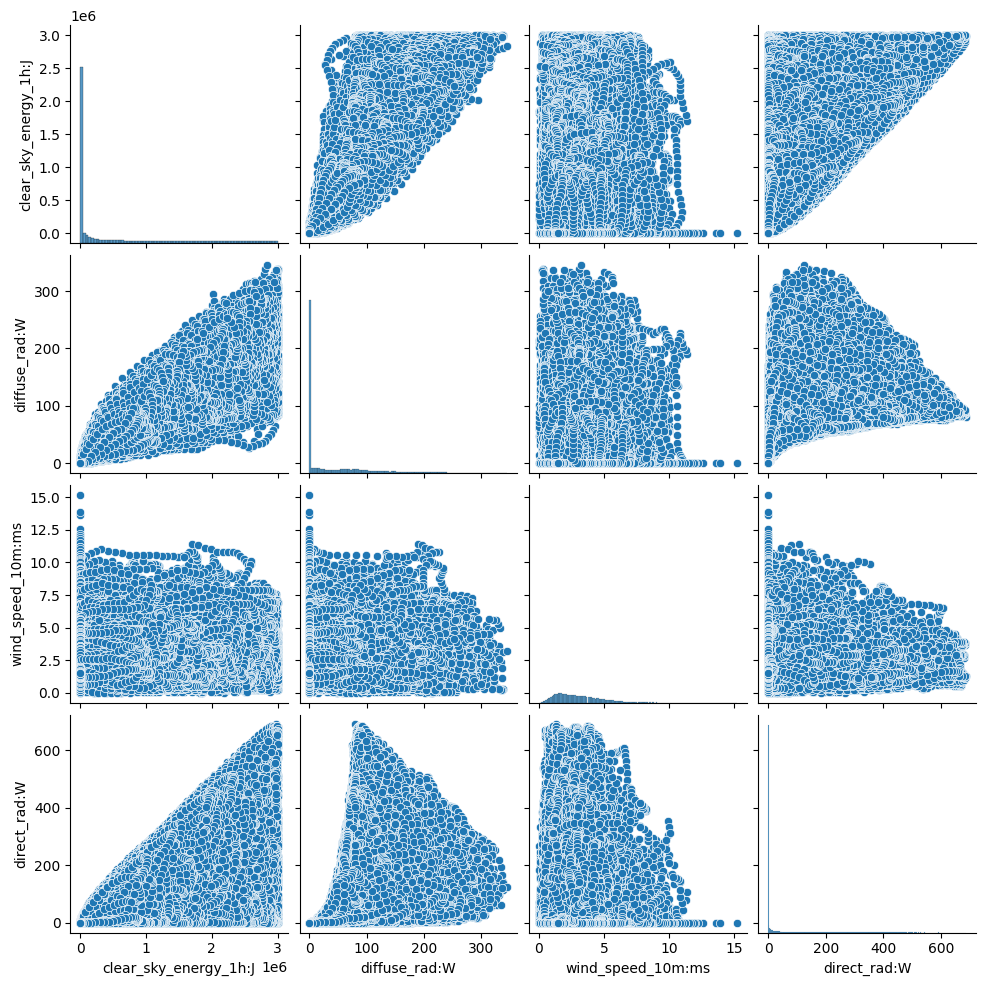

In [25]:
sns.pairplot(X_train_observed_a, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W'])
plt.show()

In [26]:
df_corr = X_train_observed_a[['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W']].dropna().corr()
df_corr

,clear_sky_energy_1h:J,diffuse_rad:W,wind_speed_10m:ms,direct_rad:W
clear_sky_energy_1h:J,1.000000,0.911178,0.013025,0.719660
diffuse_rad:W,0.911178,1.000000,-0.004529,0.555213
wind_speed_10m:ms,0.013025,-0.004529,1.000000,-0.095310
direct_rad:W,0.719660,0.555213,-0.095310,1.000000
